# The purpose of this notebook is to explore clustering options
## Focus is on three: K-Means, K-Prototypes and DBSCAN

### Setup

In [2]:
# Load helpers and custom dataset class
from __init__ import (PricingWizardDataset, 
                      condition_encoding,
                      filter_rare_categories
                      )

# Data manipulation 
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

# Machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, Birch, AgglomerativeClustering
try:
    from kmodes.kprototypes import KPrototypes
except:
    !pip install kmodes
    from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import StandardScaler

# Other
import os
try:
    import session_info
except:
    !pip install session_info
    import session_info
import session_info


In [3]:
# Set plotting style
sns.set_theme()
sns.set_style("whitegrid")

In [4]:
# Data loading
data = PricingWizardDataset(
    filename = 'post_preprocessing_without_dummies.csv'
)

Dataset Loaded: post_preprocessing_without_dummies
	Number of Rows: 283055
	Number of Columns: 22
	Outlier Removal: True
	Train Size: 0.8
	Test Size: 0.2
	Random State: 42


In [5]:
# Print head of data
data.head()

,classified_id,listed_at_date,user_id,classified_price,listing_price,favourites,viewed_count,brand_name,condition_name,color_name,...,subsubcategory_name,subsubsubcategory_name,classified_price_standardized,viewed_count_standardized,favourites_standardized,classified_price_normalized,viewed_count_normalized,favourites_normalized,log_listing_price,log_viewed_count
0,30343099,2023-09-06,2425635,900,1299,10,145,Air Jordan,Almost as new,Black,...,Men,Sneakers,0.933785,0.706555,0.183100,0.118236,0.013349,0.032573,7.170120,4.983607
1,30346312,2023-09-06,144602,225,350,12,119,Ganni,Almost as new,Multi,...,Clothes,Skirts,-0.370245,0.459288,0.362075,0.028056,0.010956,0.039088,5.860786,4.787492
2,30364278,2023-09-07,2028837,120,120,38,209,One Vintage,Good but used,Multi,...,Women,Women,-0.573094,1.315213,2.688753,0.014028,0.019241,0.123779,4.795791,5.347108
3,30406315,2023-09-10,1953400,450,450,5,41,Ralph Lauren,"New, still with price",Navy,...,Clothes,T-shirts,0.064432,-0.282514,-0.264338,0.058116,0.003775,0.016287,6.111467,3.737670
4,30420441,2023-09-11,2202926,500,600,14,208,Air Jordan,Never used,Beige,...,Men,Sneakers,0.161027,1.305703,0.541050,0.064796,0.019149,0.045603,6.398595,5.342334


In [6]:
# Print columns of data
data.columns

Index(['classified_id', 'listed_at_date', 'user_id', 'classified_price',
       'listing_price', 'favourites', 'viewed_count', 'brand_name',
       'condition_name', 'color_name', 'category_name', 'subcategory_name',
       'subsubcategory_name', 'subsubsubcategory_name',
       'classified_price_standardized', 'viewed_count_standardized',
       'favourites_standardized', 'classified_price_normalized',
       'viewed_count_normalized', 'favourites_normalized', 'log_listing_price',
       'log_viewed_count'],
      dtype='object')

# Data setup

### At the minimum, we operate on the numeric columns: views, favs, price, condition (all scaled)

In [7]:
# Clustering preprocessing
def clustering_baseline_pipeline(df):
    # Filter out rare subsubsub categories and ordinally encode conditions
    df = filter_rare_categories(df, 'subsubsubcategory_name', 'subsubcategory_name')
    df = condition_encoding(df)

    # Subtracting brands with less than 30 listings
    brands = df['brand_name'].value_counts()
    brands = brands[brands < 30].index

    df.loc[df[df.brand_name.isin(brands)].index, 'brand_name'] = 'Other'

    # Extracting relevant columns for clustering
    baseline_df = df[['listing_price','viewed_count', 'favourites', 'condition_name']]

    # Numeric Columns
    num_col = (baseline_df.select_dtypes('integer') +
            baseline_df.select_dtypes('float')).columns.to_list()

    scaler = StandardScaler()

    # Apply the scaler to the columns
    baseline_df[num_col] = scaler.fit_transform(baseline_df[num_col])

    return baseline_df

In [8]:
# Copy dataframe
df = data.df.copy()

# Apply clustering pipeline
df = clustering_baseline_pipeline(df)

/var/folders/v_/xl6xsh6x00990b93wzxm2j8c0000gn/T/ipykernel_60537/1216631863.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  baseline_df[num_col] = scaler.fit_transform(baseline_df[num_col])


In [9]:
# Vieweing head of transformed data
df.head(2)

,listing_price,viewed_count,favourites,condition_name
0,1.567128,0.975725,0.237754,-0.166384
1,-0.177686,0.652944,0.439490,-0.166384


# Visualisation functions for external validation
### The purpose of these functions is to enable the logical assessment of the splits within the resulting clusters by category, price etc.

In [10]:
# Functin for stacked bars plot
def create_stacked_bar_plot(df, column_name, cluster_col, methodology_str):
    # Check if the provided column name exists in the DataFrame
    if column_name not in df.columns:
        raise ValueError(f"Column '{column_name}' not found in the DataFrame.")

    # Check if 'Cluster' column exists
    if cluster_col not in df.columns:
        raise ValueError("Column 'Cluster' not found in the DataFrame.")

    # Grouping the data by 'Cluster' and counting the occurrences of each category in 'column_name'
    grouped_data = df.groupby([cluster_col, column_name]).size().unstack(fill_value=0)

    # Creating the stacked bar plot
    grouped_data.plot(kind='bar', stacked=True, figsize=(10, 6))

    # Adding labels and title
    plt.xlabel('Cluster')
    plt.ylabel('Count')
    plt.title(f'Stacked Bar Plot of {column_name} by Cluster following {methodology_str}')
    plt.legend(title=column_name, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

    # Showing the plot
    plt.show()

# Functin for cluster boxplots
def create_cluster_boxplots(df, cluster_col, methodology_str):
    # Check if the required columns exist in the DataFrame
    if cluster_col not in df.columns:
        raise ValueError("Column 'Cluster' not found in the DataFrame.")
    if 'listing_price' not in df.columns:
        raise ValueError("Column 'listing_price' not found in the DataFrame.")

    # Creating the boxplot
    plt.figure(figsize=(12, 6))
    sns.boxplot(x=cluster_col, y='listing_price', data=df)

    # Adding labels and title
    plt.xlabel('Cluster')
    plt.ylabel('Listing Price')
    plt.title(f'Boxplot of Listing Prices by Cluster following {methodology_str}')
    plt.ylim(0, 5000)
    # Showing the plot
    plt.show()

# Centroid-based: K-Means

#### Compute ideal number of components via PCA

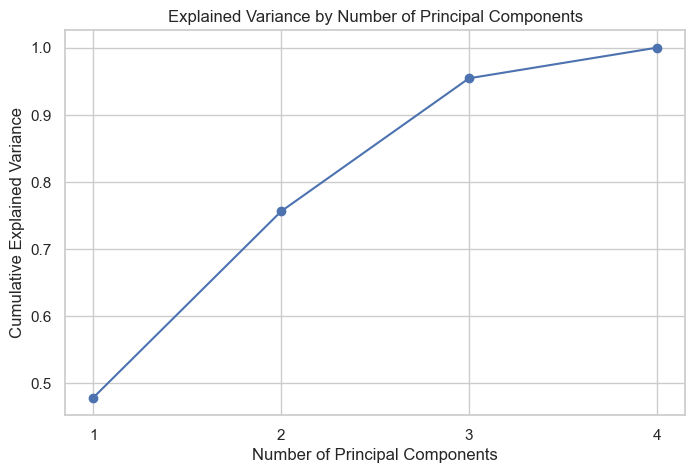

In [11]:
# Apply PCA
pca = PCA(n_components=None)
pca.fit(df)

# Explained variance
explained_variance = pca.explained_variance_ratio_

# Plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), np.cumsum(explained_variance), marker='o')
plt.title('Explained Variance by Number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.xticks(range(1, len(explained_variance) + 1))
plt.grid(True)
plt.show()

#### Assert number of PCs = 3

In [12]:
pca = PCA(n_components=3)
baseline_pca = pca.fit_transform(df)

In [13]:
# Print pcas
baseline_pca[:3]

array([[ 1.32893466,  0.55019907,  1.14143053],
       [ 0.66922411, -0.39082384, -0.21507419],
       [ 2.98981488, -1.95142108, -0.80508727]])

#### Compute ideal number of clusters using elbow method

Fitting KMeans for 3...
Fitting KMeans for 4...
Fitting KMeans for 5...
Fitting KMeans for 6...
Fitting KMeans for 7...
Fitting KMeans for 8...
Fitting KMeans for 9...
Fitting KMeans for 10...


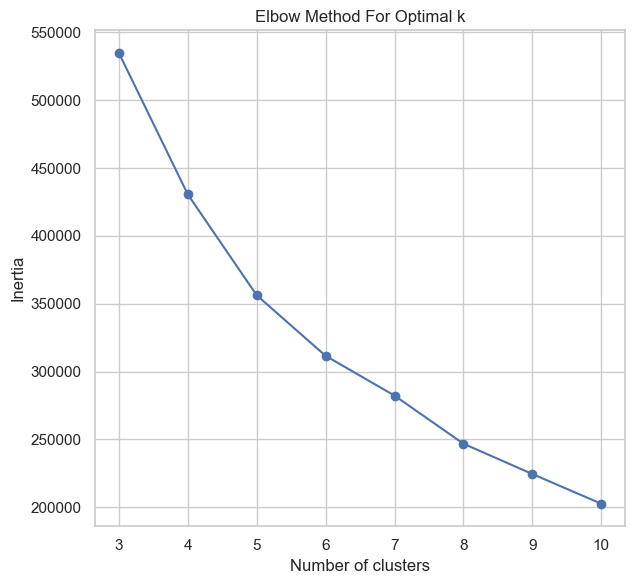

In [55]:
# Repeating the elbow method for KMeans clustering with the PCA transformed data
inertia = []
K_range = range(3, 11)  # Testing for k=3 to 10

# Looping through each value of k
for k in K_range:
    # Printing the value of k
    print(f'Fitting KMeans for {k}...')
    
    # Instantiating and fitting KMeans with the current value of k
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(baseline_pca)
    
    # Appending the inertia to the list of inertias
    inertia.append(kmeans.inertia_)

# Plotting the Elbow Method Graph
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.grid(True)

plt.tight_layout()
plt.show()

Not a clear elbow, but maybe the curve after 5 or 6 is less steep, so we'll use 5
#### Perform clustering: PLEASE ADJUST N CLUSTERS VAR BASED ON GRAPH ABOVE

In [56]:
# Building Optimal Cluster Model based on earlier method (KMeans)

# Optimal number of clusters
n_clusters = 5

# Building the model
kmeans_model = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_model.fit(baseline_pca)

# Extracting cluster labels
k_means_cluster_labels = kmeans_model.labels_

/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


#### Results: Visualize clusters in space along three PCs

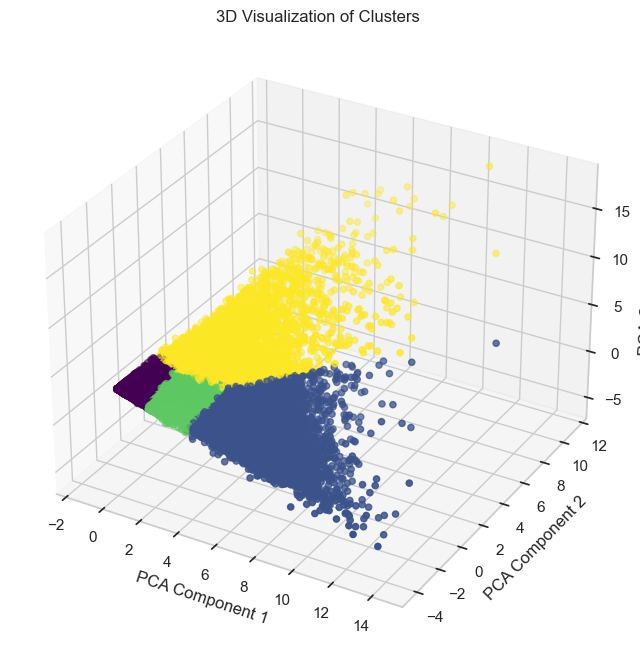

In [57]:
# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot using the first three PCA components
ax.scatter(baseline_pca[:, 0], baseline_pca[:, 1], baseline_pca[:, 2], c=k_means_cluster_labels, cmap='viridis', marker='o')

# Labeling the axes
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
ax.set_title('3D Visualization of Clusters')

# Show plot
plt.show()

#### Append cluster labels to initial dataframe

In [58]:
data.df["Cluster"] = k_means_cluster_labels

#### Extrinsic evaluation

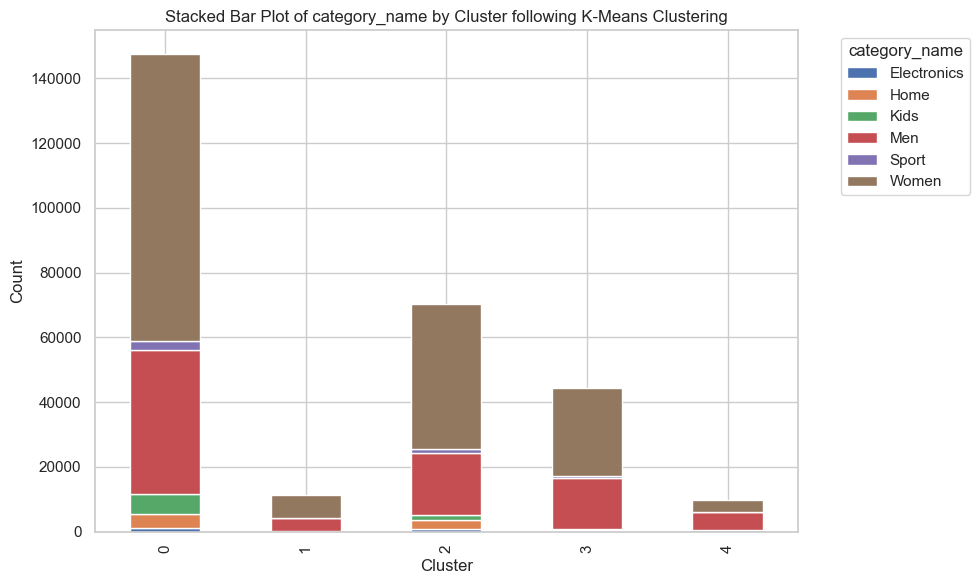

In [59]:
create_stacked_bar_plot(data.df, "category_name", "Cluster", "K-Means Clustering")

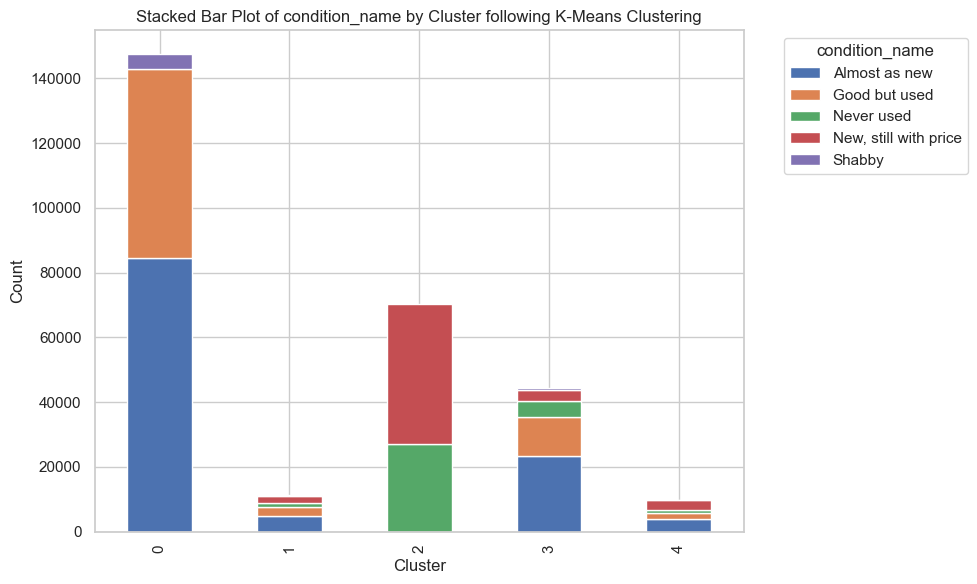

In [61]:
create_stacked_bar_plot(data.df, "condition_name", "Cluster", "K-Means Clustering")

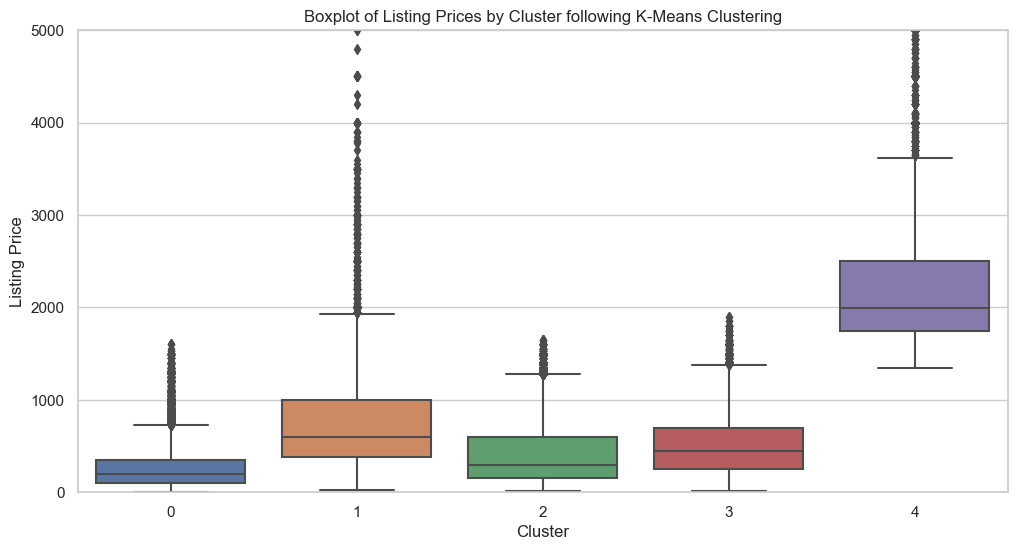

In [62]:
create_cluster_boxplots(data.df, "Cluster", "K-Means Clustering")

#### Intrinsic evaluation: WCSS

In [63]:
wcss = kmeans_model.inertia_
print(wcss)

356252.02417441894


# Centroid-based: K-Prototypes

In [64]:
# Reset dataset, used during modelling and overwrites any previous changes
data.reset_dataset()

# Extract the dataframe
df = data.df.copy()

# Filter out rare subsubsub categories and ordinally encode conditions
df = filter_rare_categories(df, 'subsubsubcategory_name', 'subsubcategory_name')
df = condition_encoding(df)

# Subtracting brands with less than 30 listings
brands = df['brand_name'].value_counts()
brands = brands[brands < 30].index

df.loc[df[df.brand_name.isin(brands)].index, 'brand_name'] = 'Other'    

# Extracting relevant columns for clustering
cluster_data = df[['brand_name','subsubsubcategory_name','listing_price','viewed_count', 'condition_name']]

# Numeric Columns
num_col = (cluster_data.select_dtypes('integer') +
           cluster_data.select_dtypes('float')).columns.to_list()

cluster_data_norm = cluster_data.copy()

cluster_data_norm.loc[:, num_col] = StandardScaler().fit_transform(cluster_data[num_col])

In [71]:
# Initalize models (Finding clusters here included testing different cluster numbers as the computation time is quite long, 
# making it difficult to do this in a systematic loop fasho)
model = KPrototypes(n_clusters=4, init='Cao', n_jobs=-1) 

# Fit and predict clusters for data
clusters = model.fit_predict(cluster_data_norm.to_numpy(), categorical=[0,1])

In [72]:
# Add clusters to dataframe
df['cluster'] = clusters
cluster_data['cluster'] = clusters

/var/folders/v_/xl6xsh6x00990b93wzxm2j8c0000gn/T/ipykernel_56209/3082798370.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_data['cluster'] = clusters


In [73]:
# Evaluate clusters
grouped_df = df.groupby('cluster').agg(
    mean_listing_price = ('listing_price', 'mean'),
    mean_views = ('viewed_count', 'mean'),
    top_5_brands = ('brand_name', lambda x: x.value_counts().index[0:5]),
    sub_categories = ('subsubcategory_name', lambda x: x.value_counts().index[0:5]),
    subsub_cateogries = ('subsubsubcategory_name', lambda x: x.value_counts().index[0:5]),
    count = ('classified_id', 'count'))

grouped_df["share"] = grouped_df["count"] / len(df)

grouped_df

,mean_listing_price,mean_views,top_5_brands,sub_categories,subsub_cateogries,count,share
cluster,,,,,,,
0,349.872468,45.857646,"[Zara, Stussy, Adidas, Nike, H&M]","[Clothes, Women, Men, Accessories, Home]","[T-shirts, Sneakers, Trousers, Dresses, Tops]",68681,0.242642
1,704.145109,268.351568,"[Stone Island, Carhartt, Stussy, Planet Nusa, ...","[Clothes, Women, Men, Accessories, Sportswear]","[Jackets, Knitwear, Sneakers, Trousers, T-shirts]",24678,0.087184
2,289.917620,45.447265,"[Carhartt, Nike, Zara, Ganni, One Vintage]","[Clothes, Women, Men, Home, Accessories]","[Trousers, Jeans, Sneakers, T-shirts, Jackets]",170552,0.602540
3,1858.128239,66.513581,"[Adidas, UGG, Polo Ralph Lauren, Nike, Moncler]","[Women, Clothes, Men, Electronics, Smartphones...","[Sneakers, Jackets, Flats, Boots, Shirts]",19144,0.067633


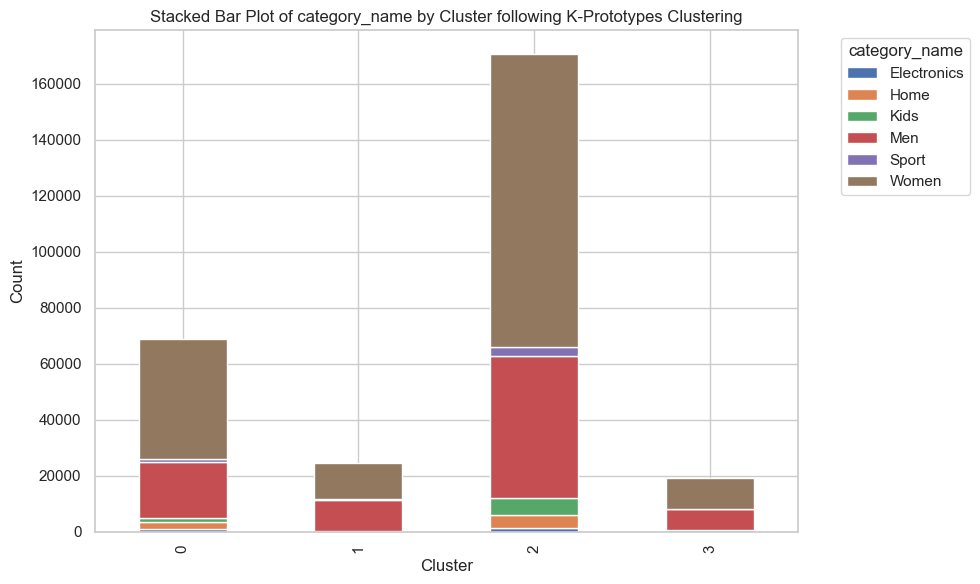

In [74]:
create_stacked_bar_plot(df, "category_name", "cluster", "K-Prototypes Clustering")

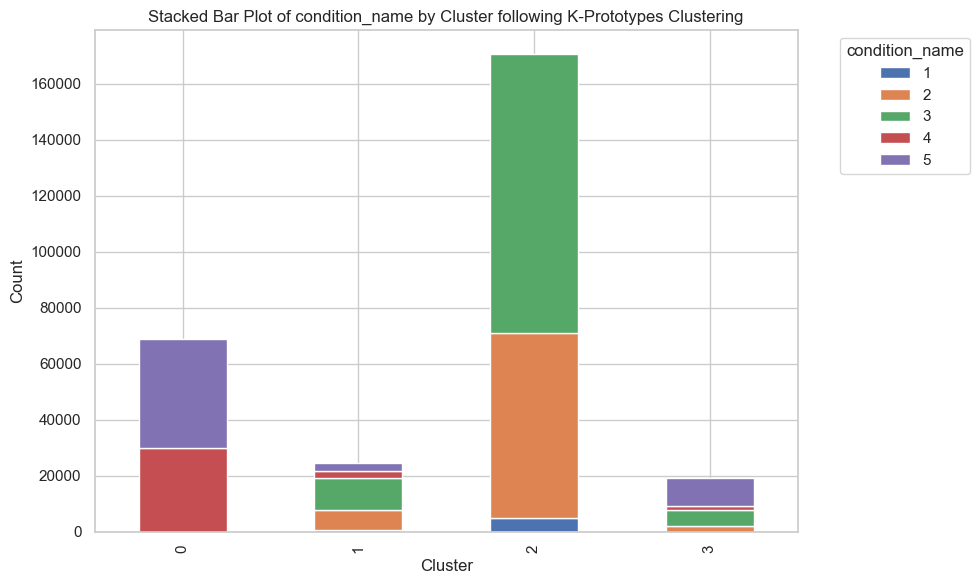

In [75]:
create_stacked_bar_plot(df, "condition_name", "cluster", "K-Prototypes Clustering")

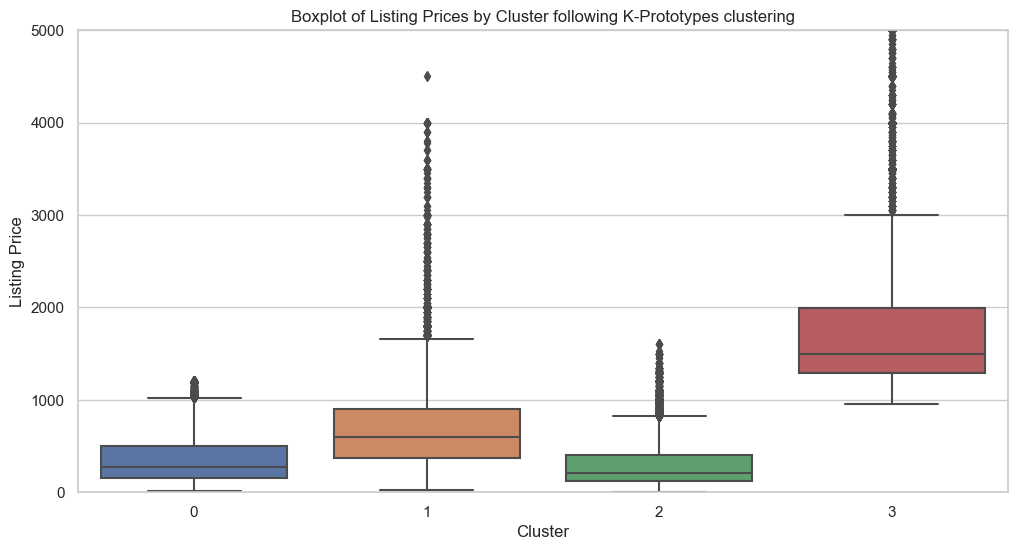

In [76]:
create_cluster_boxplots(df, "cluster", "K-Prototypes clustering")

## Visualisation of clusters in best performing model

In [82]:
cluster_data

,brand_name,subsubsubcategory_name,listing_price,viewed_count,condition_name,cluster
0,Air Jordan,Sneakers,1299,145,3,3
1,Ganni,Skirts,350,119,3,2
2,One Vintage,Women,120,209,2,1
3,Ralph Lauren,T-shirts,450,41,5,0
4,Air Jordan,Sneakers,600,208,4,1
...,...,...,...,...,...,...
286565,Yves Saint Laurent,Other,190,23,4,0
286566,Dr. Martens,Boots,800,25,4,0
286567,Bitte Kai Rand,Dresses,270,89,3,2
286568,Vintage,Sweatshirts,250,44,2,2


In [80]:
# Let's choose the first three numeric columns for this purpose
subset_df = clustering_df[['log_listing_price_normalized', 'brand_name_normalized', 'condition_name_normalized']]

# Visualizing the specified clustering in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot using the first three dimensions and coloring by cluster
scatter = ax.scatter(subset_df['log_listing_price_normalized'], subset_df['brand_name_normalized'], subset_df['condition_name_normalized'], 
                     c=clustering_df['Cluster'], cmap='viridis', marker='o', alpha=0.1)

# Adding labels and title
ax.set_xlabel('Log Listing Price')
ax.set_ylabel('Encoded Brand')
ax.set_zlabel('Encoded Condition')
ax.set_title('3D Visualization of Clustering')

# Adding a legend for clusters
plt.legend(*scatter.legend_elements(), title="Clusters")

plt.show()

KeyError: "None of [Index(['log_listing_price_normalized', 'brand_name_normalized',\n       'condition_name_normalized'],\n      dtype='object')] are in the [columns]"

# Density-based: DBSCAN

In [62]:
# Performing DBSCAN clustering
dbscan = DBSCAN(eps=2, min_samples=10)
clusters = dbscan.fit_predict(baseline_pca[:50000])

In [67]:
dbscan = DBSCAN(eps=.5, min_samples=2000)
clusters = dbscan.fit_predict(baseline_pca[:50000])

# Add the cluster labels to your DataFrame
dbscan_subset['Cluster'] = clusters

# Check the first few rows
print(dbscan_subset.head())

   listing_price  viewed_count  favourites  condition_name  Cluster
0       1.567128      0.975725    0.237754       -0.166384       -1
1      -0.177686      0.652944    0.439490       -0.166384        0
2      -0.600560      1.770264    3.062056       -1.093762       -1
3       0.006172     -0.315400   -0.266586        1.688371        3
4       0.281959      1.757849    0.641226        0.760993       -1


/var/folders/v_/xl6xsh6x00990b93wzxm2j8c0000gn/T/ipykernel_60537/1953691653.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dbscan_subset['Cluster'] = clusters


#### Visualise

In [68]:
dbscan_data = data.df.head(50000).copy()
dbscan_data["Cluster"] = clusters

In [69]:
# Evaluate clusters
grouped_df = dbscan_data.groupby('Cluster').agg(
    mean_listing_price = ('listing_price', 'mean'),
    mean_views = ('viewed_count', 'mean'),
    top_5_brands = ('brand_name', lambda x: x.value_counts().index[0:5]),
    sub_categories = ('subsubcategory_name', lambda x: x.value_counts().index[0:5]),
    subsub_cateogries = ('subsubsubcategory_name', lambda x: x.value_counts().index[0:5]),
    count = ('classified_id', 'count'))

grouped_df["share"] = grouped_df["count"] / len(df)

grouped_df

,mean_listing_price,mean_views,top_5_brands,sub_categories,subsub_cateogries,count,share
Cluster,,,,,,,
-1,816.036246,145.388171,"[Ganni, One Vintage, Air Jordan, Corteiz, Stin...","[Clothes, Women, Men, Accessories, Smartphones...","[Sneakers, Jackets, Knitwear, Dresses, Trousers]",16333,0.057703
0,302.935096,44.720285,"[Ganni, One Vintage, Mads Nørgaard, Levi's, St...","[Clothes, Women, Accessories, Men, Til drenge]","[Dresses, Shirts, Jeans, T-shirts, Knitwear]",17811,0.062924
1,226.968030,39.852065,"[One Vintage, Ganni, Levi's, Mads Nørgaard, Ra...","[Clothes, Women, Men, Accessories, Til drenge]","[Jeans, Knitwear, T-shirts, Shirts, Trousers]",10072,0.035583
2,253.021217,29.155382,"[Mads Nørgaard, Ganni, Levi's, Maanesten, COS]","[Clothes, Women, Accessories, Men, Fragrances]","[Dresses, Jeans, Shirts, T-shirts, Trousers]",3205,0.011323
3,278.282280,25.642885,"[Ralph Lauren, Mads Nørgaard, Ganni, Levi's, C...","[Clothes, Women, Accessories, Men, Skin care]","[T-shirts, Dresses, Jeans, Trousers, Shirts]",2579,0.009111


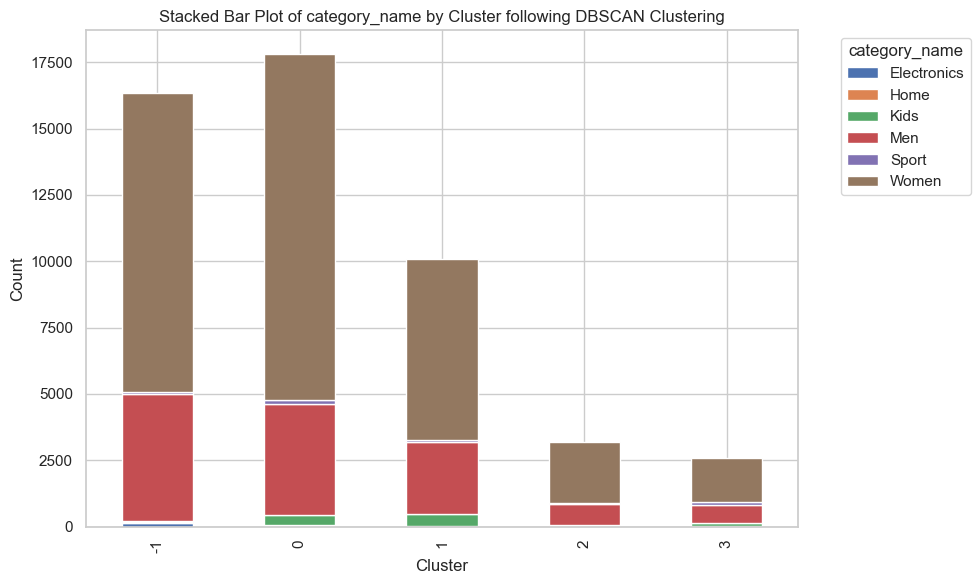

In [70]:
create_stacked_bar_plot(dbscan_data, "category_name", "Cluster", "DBSCAN Clustering")

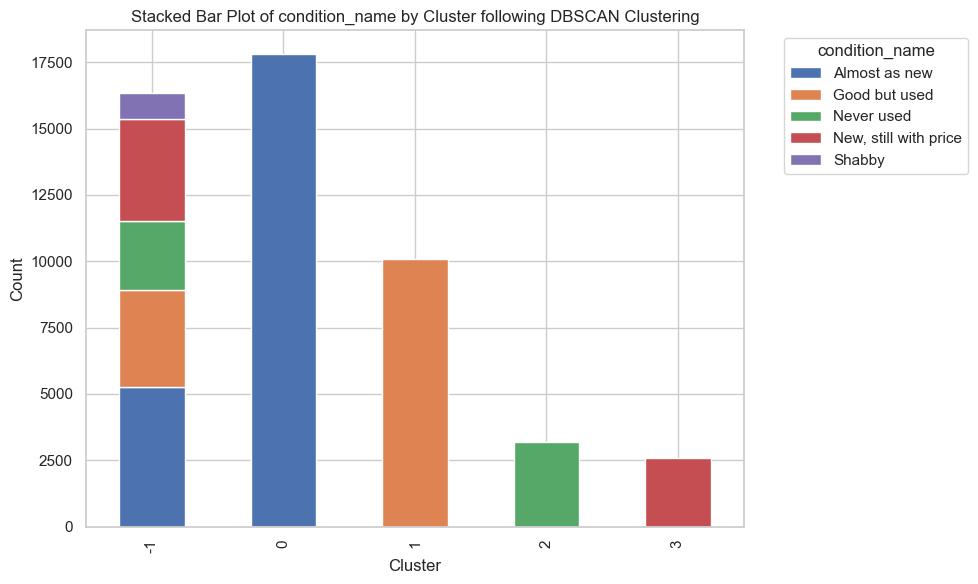

In [71]:
create_stacked_bar_plot(dbscan_data, "condition_name", "Cluster", "DBSCAN Clustering")

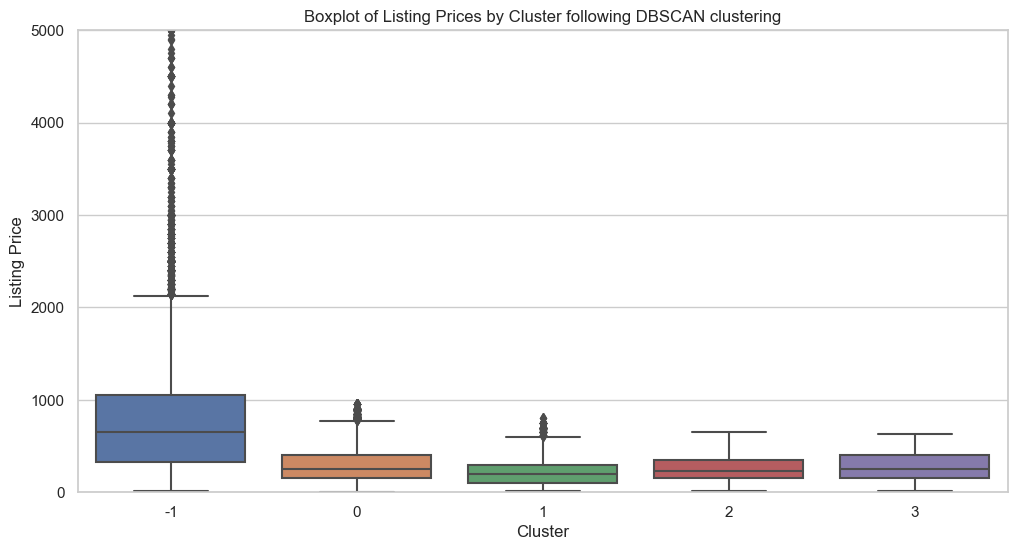

In [72]:
create_cluster_boxplots(dbscan_data, "Cluster", "DBSCAN clustering")